In [1]:
import matplotlib.pyplot as plt
import nengo
import nengo_dl
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import collections
import pickle

import nengo_loihi
from nengo.utils.ensemble import tuning_curves

import _init_paths

from configs.exp_configs import tf_exp_cfg as tf_cfg, nengo_dl_cfg as ndl_cfg
from utils.base_utils.data_prep_utils import get_batches_of_exp_dataset, get_exp_dataset
from utils.base_utils.exp_utils import get_shuffled_lists_in_unison
from utils.nengo_dl_utils import get_nengo_dl_model
from utils.nengo_loihi_utils import (
    get_loihi_adapted_avam_net_for_2x2_max_pooling, configure_ensemble_for_2x2_max_join_op)
from utils.results_analysis_utils.analyse_results import get_isi_distribution

# MAX-JOP POC

## Run MAX-JOP Code

In [2]:
P1, P2, P3, P4 = 10, 8, 4, 6
FONTSIZE=16

with nengo.Network() as net1:
  ens = nengo.Ensemble(n_neurons=4, dimensions=1, gain=1000*np.ones(4), bias=np.zeros(4), seed=0,
                      neuron_type=nengo_loihi.neurons.LoihiSpikingRectifiedLinear(
                        amplitude=1/1000,
                        initial_state={"voltage": np.zeros(4)}))
  inpt = nengo.Node(output = lambda t: [1.0 if int(t*1000)%P1 == 0 else 0,
                                        1.0 if int(t*1000)%P2 == 0 else 0,
                                        1.0 if int(t*1000)%P3 == 0 else 0,
                                        1.0 if int(t*1000)%P4 == 0 else 0])
  
  nengo.Connection(inpt, ens.neurons, synapse=None)
  neuron_probe = nengo.Probe(ens.neurons[3], synapse=0.01) # Probe soma which is at index 3.

In [3]:
with nengo_loihi.Simulator(net1) as loihi_sim:
  configure_ensemble_for_2x2_max_join_op(loihi_sim, ens)
  loihi_sim.run(0.1)

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:44687
INFO:DRV:      Host server up..............Done 0.25s
INFO:DRV:      Encoding axons/synapses.....Done 3.41ms
INFO:DRV:      Compiling Embedded snips....Done 0.26s
INFO:DRV:      Compiling MPDS Registers....Done 0.83ms
INFO:HST:  Args chip=0 cpu=0 /homes/rgaurav/nxsdk_1_nengo_loihi/lib/python3.8/site-packages/nxsdk/driver/compilers/../../../temp/1649684484.1000626/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 
INFO:HST:  Nx...
INFO:DRV:      Booting up..................Done 0.64s
INFO:DRV:      Encoding probes.............Done 0.43ms
INFO:DRV:      Transferring probes.........Done 2.46ms
INFO:DRV:      Configuring registers.......Done 4.59ms
INFO:DRV:      Transferring spikes.........Done 6.78ms
INFO:DRV:      Executing...................Done 9.07ms
INFO:DRV:      Processing timeseries.......Done 1.99ms
INFO:DRV:  Executor: 100 timesteps.........Done 0.03s
INFO:HST:  chip=0 cpu=0 halted, status

## Run normal Max computation code.

In [4]:
with nengo.Network() as net_max:
  inpt_max = nengo.Node(output = lambda t: [1.0 if int(t*1000)%P1 == 0 else 0,
                                        1.0 if int(t*1000)%P2 == 0 else 0,
                                        1.0 if int(t*1000)%P3 == 0 else 0,
                                        1.0 if int(t*1000)%P4 == 0 else 0])
  otpt_max = nengo.Node(output=lambda t, x: max(x), size_in=4)
  nengo.Connection(inpt_max, otpt_max, synapse=0.01)
  otpt_probe_max = nengo.Probe(otpt_max, synapse=None)

In [5]:
with nengo.Simulator(net_max) as ngo_sim_max:
  ngo_sim_max.run(0.1)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

# Run Average computation code.

In [6]:
with nengo.Network() as net_avg:
  inpt_avg = nengo.Node(output = lambda t: [1.0 if int(t*1000)%P1 == 0 else 0,
                                        1.0 if int(t*1000)%P2 == 0 else 0,
                                        1.0 if int(t*1000)%P3 == 0 else 0,
                                        1.0 if int(t*1000)%P4 == 0 else 0])
  otpt_avg = nengo.Node(output=lambda t, x: np.mean(x), size_in=4)
  nengo.Connection(inpt_avg, otpt_avg, synapse=0.01)
  otpt_probe_avg = nengo.Probe(otpt_avg, synapse=None)

In [7]:
with nengo.Simulator(net_avg) as ngo_sim_avg:
  ngo_sim_avg.run(0.1)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

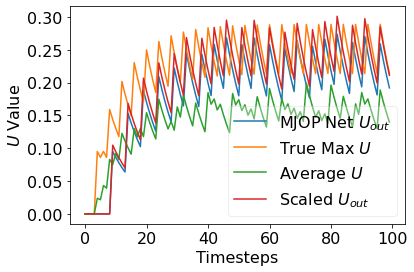

In [8]:
plt.plot(loihi_sim.data[neuron_probe], label="MJOP Net $U_{out}$")
plt.plot(ngo_sim_max.data[otpt_probe_max], label="True Max $U$")
plt.plot(ngo_sim_avg.data[otpt_probe_avg], label="Average $U$")
plt.plot(loihi_sim.data[neuron_probe]*1.1, label="Scaled $U_{out}$")
#plt.plot(loihi_sim.data[neuron_probe]*1.5, label="Scaled $U_{out}$, 1.5")
plt.xlabel("Timesteps", fontsize=FONTSIZE)
plt.ylabel("$U$ Value", fontsize=FONTSIZE)
plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.legend(framealpha=0.325, fontsize=FONTSIZE)
plt.savefig("max_jop_poc", dpi=450, bbox_inches = "tight")

# TUNING CURVES

In [9]:
with nengo.Network() as net3:
  ens = nengo.Ensemble(n_neurons=2, dimensions=1, 
                      encoders=[[1], [-1]], radius=2.5,
                      max_rates=[200, 200], intercepts=[0, 0],
                       neuron_type=nengo_loihi.neurons.SpikingRectifiedLinear())

In [10]:
with nengo.Simulator(net3) as ngo_sim3:
  inputs, activities = tuning_curves(ens, ngo_sim3)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

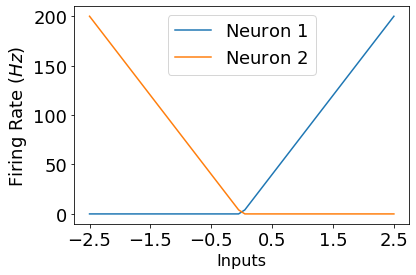

In [11]:
plt.plot(inputs, activities, label=["Neuron $1$", "Neuron $2$"])
plt.xlabel("Inputs", fontsize=16)
plt.ylabel("Firing Rate ($Hz$)", fontsize=18)
plt.xticks(np.arange(-2.5, 2.6, 1))
plt.yticks(np.arange(0, 201, 50))
plt.tick_params(labelsize=18)
plt.legend(prop={"size": 18}) # FontSize = 16
plt.savefig("avam_tuning_curves", dpi=450, bbox_inches = "tight")

## |x| Calculation

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

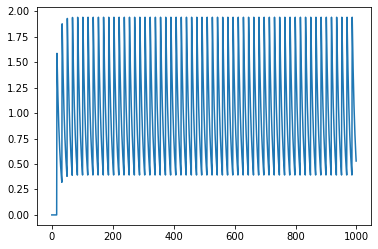

In [13]:
with nengo.Network() as net3:
  ens = nengo.Ensemble(n_neurons=2, dimensions=1, 
                      encoders=[[1], [-1]], radius=2.5,
                      max_rates=[150, 150], intercepts=[0, 0],
                       neuron_type=nengo_loihi.neurons.LoihiSpikingRectifiedLinear())
                      #neuron_type=nengo_loihi.neurons.SpikingRectifiedLinear()) => Unsaturated Output for larger
                                                                                    # input than radius.
  inpt = nengo.Node(-1)
  otpt = nengo.Node(size_in=1)
  nengo.Connection(inpt, ens, synapse=None)
  nengo.Connection(ens.neurons[0], otpt, synapse=0.010, transform=2.5/150)
  nengo.Connection(ens.neurons[1], otpt, synapse=0.010, transform=2.5/150)
  
  otpt_probe = nengo.Probe(otpt, synapse=None)

with nengo.Simulator(net3) as ngo_sim4:
  ngo_sim4.run(1)

plt.plot(ngo_sim4.data[otpt_probe])

# AVAM NET POC

In [18]:
net4 = get_loihi_adapted_avam_net_for_2x2_max_pooling(radius=0.25, max_rate=500, synapse=0.005)
with net4:
  inpt = nengo.Node(output = lambda t: [1.0 if int(t*1000)%P1 == 0 else 0,
                                        1.0 if int(t*1000)%P2 == 0 else 0,
                                        1.0 if int(t*1000)%P3 == 0 else 0,
                                        1.0 if int(t*1000)%P4 == 0 else 0])
  ens4 = nengo.Ensemble(
      n_neurons=1, dimensions=1, radius=1, intercepts=[0], max_rates=[250],
      neuron_type=nengo_loihi.neurons.LoihiSpikingRectifiedLinear(amplitude=1/1000)
      )
  nengo.Connection(inpt, net4.inputs, synapse=0.005)
  nengo.Connection(net4.otp_node, ens4.neurons, synapse=None)
  # Probe the input to the output neuron which is the max(max(a, b), max(c, d)).
  # print(net4.otpt_neuron.neurons.probeable)
  max_otpt_4 = nengo.Probe(net4.otp_node, synapse=None) # No Synpase since the input is already synapsed.

with nengo_loihi.Simulator(net4) as loihi_sim_4:
  loihi_sim_4.run(0.1)

/homes/rgaurav/nengo-loihi/nengo_loihi/passthrough.py:118: UserWarning: Combining two Lowpass synapses, this may change the behaviour of the network (set `remove_passthrough=False` to avoid this).
  warnings.warn(
/homes/rgaurav/nengo-loihi/nengo_loihi/block.py:214: UserWarning: tau_s is currently 0.005, which is smaller than 0.01. Overwriting tau_s with 0.01.
  warnings.warn(
/homes/rgaurav/nengo-loihi/nengo_loihi/block.py:208: UserWarning: tau_s is already set to 0.01, which is larger than 0.005. Using 0.01.
  warnings.warn(


INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:34899
INFO:DRV:      Host server up..............Done 0.16s
INFO:DRV:      Encoding axons/synapses.....Done 5.20ms
INFO:DRV:      Compiling Embedded snips....Done 0.35s
INFO:DRV:      Compiling Host snips........Done 0.66s
INFO:DRV:      Compiling MPDS Registers....Done 0.72ms
INFO:HST:  Args chip=0 cpu=0 /homes/rgaurav/nxsdk_1_nengo_loihi/lib/python3.8/site-packages/nxsdk/driver/compilers/../../../temp/1649684592.2658713/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 
INFO:HST:  Nx...
INFO:DRV:      Booting up..................Done 0.64s
INFO:DRV:      Encoding probes.............Done 0.88ms
INFO:DRV:      Transferring probes.........Done 3.32ms
INFO:DRV:      Configuring registers.......Done 8.81ms
INFO:DRV:      Transferring spikes.........Done 0.35ms
INFO:HST:  [Host] Listening for client
INFO:HST:  [Host] Connected to client
INFO:HST:  chip=0 cpu=0 time 100
INFO:HST:  chip=0 cpu=0 Waited to exit

In [19]:
net5 = get_loihi_adapted_avam_net_for_2x2_max_pooling(radius=0.30, max_rate=500, synapse=0.005)
with net5:
  inpt = nengo.Node(output = lambda t: [1.0 if int(t*1000)%P1 == 0 else 0,
                                        1.0 if int(t*1000)%P2 == 0 else 0,
                                        1.0 if int(t*1000)%P3 == 0 else 0,
                                        1.0 if int(t*1000)%P4 == 0 else 0])
  ens5 = nengo.Ensemble(
      n_neurons=1, dimensions=1, radius=1, intercepts=[0], max_rates=[250],
      neuron_type=nengo_loihi.neurons.LoihiSpikingRectifiedLinear(amplitude=1/1000)
      )
  nengo.Connection(inpt, net5.inputs, synapse=0.005)
  nengo.Connection(net5.otp_node, ens5.neurons, synapse=None)
  # Probe the input to the output neuron which is the max(max(a, b), max(c, d)).
  # print(net4.otpt_neuron.neurons.probeable)
  max_otpt_5 = nengo.Probe(net5.otp_node, synapse=None) # No Synpase since the input is already synapsed.

with nengo_loihi.Simulator(net5) as loihi_sim_5:
  loihi_sim_5.run(0.1)

INFO:DRV:  SLURM is being run in background


/homes/rgaurav/nengo-loihi/nengo_loihi/passthrough.py:118: UserWarning: Combining two Lowpass synapses, this may change the behaviour of the network (set `remove_passthrough=False` to avoid this).
  warnings.warn(
/homes/rgaurav/nengo-loihi/nengo_loihi/block.py:208: UserWarning: tau_s is already set to 0.01, which is larger than 0.005. Using 0.01.
  warnings.warn(


INFO:DRV:  Connecting to 10.212.98.106:40437
INFO:DRV:      Host server up..............Done 0.15s
INFO:DRV:      Encoding axons/synapses.....Done 4.29ms
INFO:DRV:      Compiling Embedded snips....Done 0.33s
INFO:DRV:      Compiling Host snips........Done 0.70s
INFO:DRV:      Compiling MPDS Registers....Done 2.28ms
INFO:HST:  Args chip=0 cpu=0 /homes/rgaurav/nxsdk_1_nengo_loihi/lib/python3.8/site-packages/nxsdk/driver/compilers/../../../temp/1649684595.2157395/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 
INFO:HST:  Nx...
INFO:DRV:      Booting up..................Done 0.64s
INFO:DRV:      Encoding probes.............Done 0.50ms
INFO:DRV:      Transferring probes.........Done 2.00ms
INFO:DRV:      Configuring registers.......Done 5.64ms
INFO:DRV:      Transferring spikes.........Done 0.32ms
INFO:HST:  [Host] Listening for client
INFO:HST:  [Host] Connected to client
INFO:HST:  chip=0 cpu=0 time 100
INFO:HST:  chip=0 cpu=0 Waited to exit (nonsense sum -13580)
INFO:DRV:      Execut

In [20]:
net6 = get_loihi_adapted_avam_net_for_2x2_max_pooling(radius=0.20, max_rate=500, synapse=0.005)
with net6:
  inpt = nengo.Node(output = lambda t: [1.0 if int(t*1000)%P1 == 0 else 0,
                                        1.0 if int(t*1000)%P2 == 0 else 0,
                                        1.0 if int(t*1000)%P3 == 0 else 0,
                                        1.0 if int(t*1000)%P4 == 0 else 0])
  ens6 = nengo.Ensemble(
      n_neurons=1, dimensions=1, radius=1, intercepts=[0], max_rates=[250],
      neuron_type=nengo_loihi.neurons.LoihiSpikingRectifiedLinear(amplitude=1/1000)
      )
  nengo.Connection(inpt, net6.inputs, synapse=0.005)
  nengo.Connection(net6.otp_node, ens6.neurons, synapse=None)
  # Probe the input to the output neuron which is the max(max(a, b), max(c, d)).
  # print(net4.otpt_neuron.neurons.probeable)
  max_otpt_6 = nengo.Probe(net6.otp_node, synapse=None) # No Synpase since the input is already synapsed.

with nengo_loihi.Simulator(net6) as loihi_sim_6:
  loihi_sim_6.run(0.1)

/homes/rgaurav/nengo-loihi/nengo_loihi/passthrough.py:118: UserWarning: Combining two Lowpass synapses, this may change the behaviour of the network (set `remove_passthrough=False` to avoid this).
  warnings.warn(
/homes/rgaurav/nengo-loihi/nengo_loihi/block.py:214: UserWarning: tau_s is currently 0.005, which is smaller than 0.01. Overwriting tau_s with 0.01.
  warnings.warn(
/homes/rgaurav/nengo-loihi/nengo_loihi/block.py:208: UserWarning: tau_s is already set to 0.01, which is larger than 0.005. Using 0.01.
  warnings.warn(


INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:46509
INFO:DRV:      Host server up..............Done 0.15s
INFO:DRV:      Encoding axons/synapses.....Done 4.29ms
INFO:DRV:      Compiling Embedded snips....Done 0.27s
INFO:DRV:      Compiling Host snips........Done 0.60s
INFO:DRV:      Compiling MPDS Registers....Done 0.96ms
INFO:HST:  Args chip=0 cpu=0 /homes/rgaurav/nxsdk_1_nengo_loihi/lib/python3.8/site-packages/nxsdk/driver/compilers/../../../temp/1649684598.1967294/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 
INFO:HST:  Nx...
INFO:DRV:      Booting up..................Done 0.64s
INFO:DRV:      Encoding probes.............Done 1.12ms
INFO:DRV:      Transferring probes.........Done 2.45ms
INFO:DRV:      Configuring registers.......Done 9.42ms
INFO:DRV:      Transferring spikes.........Done 0.34ms
INFO:HST:  [Host] Listening for client
INFO:HST:  [Host] Connected to client
INFO:HST:  chip=0 cpu=0 time 100
INFO:HST:  chip=0 cpu=0 Waited to exit

In [21]:
net7 = get_loihi_adapted_avam_net_for_2x2_max_pooling(radius=0.10, max_rate=500, synapse=0.005)
with net7:
  inpt = nengo.Node(output = lambda t: [1.0 if int(t*1000)%P1 == 0 else 0,
                                        1.0 if int(t*1000)%P2 == 0 else 0,
                                        1.0 if int(t*1000)%P3 == 0 else 0,
                                        1.0 if int(t*1000)%P4 == 0 else 0])
  ens7 = nengo.Ensemble(
      n_neurons=1, dimensions=1, radius=1, intercepts=[0], max_rates=[250],
      neuron_type=nengo_loihi.neurons.LoihiSpikingRectifiedLinear(amplitude=1/1000)
      )
  nengo.Connection(inpt, net7.inputs, synapse=0.005)
  nengo.Connection(net7.otp_node, ens7.neurons, synapse=None)
  # Probe the input to the output neuron which is the max(max(a, b), max(c, d)).
  # print(net4.otpt_neuron.neurons.probeable)
  max_otpt_7 = nengo.Probe(net7.otp_node, synapse=None) # No Synpase since the input is already synapsed.

with nengo_loihi.Simulator(net7) as loihi_sim_7:
  loihi_sim_7.run(0.1)

INFO:DRV:  SLURM is being run in background


/homes/rgaurav/nengo-loihi/nengo_loihi/passthrough.py:118: UserWarning: Combining two Lowpass synapses, this may change the behaviour of the network (set `remove_passthrough=False` to avoid this).
  warnings.warn(
/homes/rgaurav/nengo-loihi/nengo_loihi/block.py:208: UserWarning: tau_s is already set to 0.01, which is larger than 0.005. Using 0.01.
  warnings.warn(


INFO:DRV:  Connecting to 10.212.98.106:36769
INFO:DRV:      Host server up..............Done 0.16s
INFO:DRV:      Encoding axons/synapses.....Done 8.56ms
INFO:DRV:      Compiling Embedded snips....Done 0.31s
INFO:DRV:      Compiling Host snips........Done 0.62s
INFO:DRV:      Compiling MPDS Registers....Done 0.42ms
INFO:HST:  Args chip=0 cpu=0 /homes/rgaurav/nxsdk_1_nengo_loihi/lib/python3.8/site-packages/nxsdk/driver/compilers/../../../temp/1649684600.982261/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 
INFO:HST:  Nx...
INFO:DRV:      Booting up..................Done 0.64s
INFO:DRV:      Encoding probes.............Done 0.35ms
INFO:DRV:      Transferring probes.........Done 2.58ms
INFO:DRV:      Configuring registers.......Done 0.01s
INFO:DRV:      Transferring spikes.........Done 0.32ms
INFO:HST:  [Host] Listening for client
INFO:HST:  [Host] Connected to client
INFO:HST:  chip=0 cpu=0 time 100
INFO:HST:  chip=0 cpu=0 Waited to exit (nonsense sum -13580)
INFO:DRV:      Executin

In [22]:
net8 = get_loihi_adapted_avam_net_for_2x2_max_pooling(radius=0.50, max_rate=500, synapse=0.005)
with net8:
  inpt = nengo.Node(output = lambda t: [1.0 if int(t*1000)%P1 == 0 else 0,
                                        1.0 if int(t*1000)%P2 == 0 else 0,
                                        1.0 if int(t*1000)%P3 == 0 else 0,
                                        1.0 if int(t*1000)%P4 == 0 else 0])
  ens8 = nengo.Ensemble(
      n_neurons=1, dimensions=1, radius=1, intercepts=[0], max_rates=[250],
      neuron_type=nengo_loihi.neurons.LoihiSpikingRectifiedLinear(amplitude=1/1000)
      )
  nengo.Connection(inpt, net8.inputs, synapse=0.005)
  nengo.Connection(net8.otp_node, ens8.neurons, synapse=None)
  # Probe the input to the output neuron which is the max(max(a, b), max(c, d)).
  # print(net4.otpt_neuron.neurons.probeable)
  max_otpt_8 = nengo.Probe(net8.otp_node, synapse=None) # No Synpase since the input is already synapsed.

with nengo_loihi.Simulator(net8) as loihi_sim_8:
  loihi_sim_8.run(0.1)

/homes/rgaurav/nengo-loihi/nengo_loihi/passthrough.py:118: UserWarning: Combining two Lowpass synapses, this may change the behaviour of the network (set `remove_passthrough=False` to avoid this).
  warnings.warn(
/homes/rgaurav/nengo-loihi/nengo_loihi/block.py:214: UserWarning: tau_s is currently 0.005, which is smaller than 0.01. Overwriting tau_s with 0.01.
  warnings.warn(
/homes/rgaurav/nengo-loihi/nengo_loihi/block.py:208: UserWarning: tau_s is already set to 0.01, which is larger than 0.005. Using 0.01.
  warnings.warn(
/homes/rgaurav/nengo-loihi/nengo_loihi/builder/discretize.py:477: UserWarning: Lost 1 extra bits in weight rounding
  warnings.warn("Lost %d extra bits in weight rounding" % (-s2,))


INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:43221
INFO:DRV:      Host server up..............Done 0.15s
INFO:DRV:      Encoding axons/synapses.....Done 4.47ms
INFO:DRV:      Compiling Embedded snips....Done 0.35s
INFO:DRV:      Compiling Host snips........Done 0.72s
INFO:DRV:      Compiling MPDS Registers....Done 0.50ms
INFO:HST:  Args chip=0 cpu=0 /homes/rgaurav/nxsdk_1_nengo_loihi/lib/python3.8/site-packages/nxsdk/driver/compilers/../../../temp/1649684603.8279624/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 
INFO:HST:  Nx...
INFO:DRV:      Booting up..................Done 0.64s
INFO:DRV:      Encoding probes.............Done 0.51ms
INFO:DRV:      Transferring probes.........Done 2.40ms
INFO:DRV:      Configuring registers.......Done 5.68ms
INFO:DRV:      Transferring spikes.........Done 0.35ms
INFO:HST:  [Host] Listening for client
INFO:HST:  [Host] Connected to client
INFO:HST:  chip=0 cpu=0 time 100
INFO:HST:  chip=0 cpu=0 Waited to exit

In [23]:
net9 = get_loihi_adapted_avam_net_for_2x2_max_pooling(radius=1, max_rate=500, synapse=0.005)
with net9:
  inpt = nengo.Node(output = lambda t: [1.0 if int(t*1000)%P1 == 0 else 0,
                                        1.0 if int(t*1000)%P2 == 0 else 0,
                                        1.0 if int(t*1000)%P3 == 0 else 0,
                                        1.0 if int(t*1000)%P4 == 0 else 0])
  ens9 = nengo.Ensemble(
      n_neurons=1, dimensions=1, radius=1, intercepts=[0], max_rates=[250],
      neuron_type=nengo_loihi.neurons.LoihiSpikingRectifiedLinear(amplitude=1/1000)
      )
  nengo.Connection(inpt, net9.inputs, synapse=0.005)
  nengo.Connection(net9.otp_node, ens9.neurons, synapse=None)
  # Probe the input to the output neuron which is the max(max(a, b), max(c, d)).
  # print(net4.otpt_neuron.neurons.probeable)
  max_otpt_9 = nengo.Probe(net9.otp_node, synapse=None) # No Synpase since the input is already synapsed.

with nengo_loihi.Simulator(net9) as loihi_sim_9:
  loihi_sim_9.run(0.1)

/homes/rgaurav/nengo-loihi/nengo_loihi/passthrough.py:118: UserWarning: Combining two Lowpass synapses, this may change the behaviour of the network (set `remove_passthrough=False` to avoid this).
  warnings.warn(
/homes/rgaurav/nengo-loihi/nengo_loihi/block.py:214: UserWarning: tau_s is currently 0.005, which is smaller than 0.01. Overwriting tau_s with 0.01.
  warnings.warn(
/homes/rgaurav/nengo-loihi/nengo_loihi/block.py:208: UserWarning: tau_s is already set to 0.01, which is larger than 0.005. Using 0.01.
  warnings.warn(
/homes/rgaurav/nengo-loihi/nengo_loihi/builder/discretize.py:477: UserWarning: Lost 2 extra bits in weight rounding
  warnings.warn("Lost %d extra bits in weight rounding" % (-s2,))


INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:43281
INFO:DRV:      Host server up..............Done 0.15s
INFO:DRV:      Encoding axons/synapses.....Done 4.75ms
INFO:DRV:      Compiling Embedded snips....Done 0.36s
INFO:DRV:      Compiling Host snips........Done 0.68s
INFO:DRV:      Compiling MPDS Registers....Done 0.90ms
INFO:HST:  Args chip=0 cpu=0 /homes/rgaurav/nxsdk_1_nengo_loihi/lib/python3.8/site-packages/nxsdk/driver/compilers/../../../temp/1649684606.8618634/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 
INFO:HST:  Nx...
INFO:DRV:      Booting up..................Done 0.64s
INFO:DRV:      Encoding probes.............Done 0.53ms
INFO:DRV:      Transferring probes.........Done 2.77ms
INFO:DRV:      Configuring registers.......Done 6.99ms
INFO:DRV:      Transferring spikes.........Done 0.60ms
INFO:HST:  [Host] Listening for client
INFO:HST:  [Host] Connected to client
INFO:HST:  chip=0 cpu=0 time 100
INFO:HST:  chip=0 cpu=0 Waited to exit

In [24]:
net10 = get_loihi_adapted_avam_net_for_2x2_max_pooling(radius=0.05, max_rate=500, synapse=0.005)
with net10:
  inpt = nengo.Node(output = lambda t: [1.0 if int(t*1000)%P1 == 0 else 0,
                                        1.0 if int(t*1000)%P2 == 0 else 0,
                                        1.0 if int(t*1000)%P3 == 0 else 0,
                                        1.0 if int(t*1000)%P4 == 0 else 0])
  ens10 = nengo.Ensemble(
      n_neurons=1, dimensions=1, radius=1, intercepts=[0], max_rates=[250],
      neuron_type=nengo_loihi.neurons.LoihiSpikingRectifiedLinear(amplitude=1/1000)
      )
  nengo.Connection(inpt, net10.inputs, synapse=0.005)
  nengo.Connection(net10.otp_node, ens10.neurons, synapse=None)
  # Probe the input to the output neuron which is the max(max(a, b), max(c, d)).
  # print(net4.otpt_neuron.neurons.probeable)
  max_otpt_10 = nengo.Probe(net10.otp_node, synapse=None) # No Synpase since the input is already synapsed.

with nengo_loihi.Simulator(net10) as loihi_sim_10:
  loihi_sim_10.run(0.1)

/homes/rgaurav/nengo-loihi/nengo_loihi/passthrough.py:118: UserWarning: Combining two Lowpass synapses, this may change the behaviour of the network (set `remove_passthrough=False` to avoid this).
  warnings.warn(
/homes/rgaurav/nengo-loihi/nengo_loihi/block.py:208: UserWarning: tau_s is already set to 0.01, which is larger than 0.005. Using 0.01.
  warnings.warn(
/homes/rgaurav/nengo-loihi/nengo_loihi/builder/discretize.py:477: UserWarning: Lost 1 extra bits in weight rounding
  warnings.warn("Lost %d extra bits in weight rounding" % (-s2,))


INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:33065
INFO:DRV:      Host server up..............Done 0.16s
INFO:DRV:      Encoding axons/synapses.....Done 3.78ms
INFO:DRV:      Compiling Embedded snips....Done 0.35s
INFO:DRV:      Compiling Host snips........Done 0.69s
INFO:DRV:      Compiling MPDS Registers....Done 0.80ms
INFO:HST:  Args chip=0 cpu=0 /homes/rgaurav/nxsdk_1_nengo_loihi/lib/python3.8/site-packages/nxsdk/driver/compilers/../../../temp/1649684609.8282073/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 
INFO:HST:  Nx...
INFO:DRV:      Booting up..................Done 0.64s
INFO:DRV:      Encoding probes.............Done 0.87ms
INFO:DRV:      Transferring probes.........Done 4.97ms
INFO:DRV:      Configuring registers.......Done 7.55ms
INFO:DRV:      Transferring spikes.........Done 0.35ms
INFO:HST:  [Host] Listening for client
INFO:HST:  [Host] Connected to client
INFO:HST:  chip=0 cpu=0 time 100
INFO:HST:  chip=0 cpu=0 Waited to exit

In [25]:
with nengo.Network() as net_max:
  inpt_max = nengo.Node(output = lambda t: [1.0 if int(t*1000)%P1 == 0 else 0,
                                        1.0 if int(t*1000)%P2 == 0 else 0,
                                        1.0 if int(t*1000)%P3 == 0 else 0,
                                        1.0 if int(t*1000)%P4 == 0 else 0])
  otpt_max = nengo.Node(output=lambda t, x: max(x), size_in=4)
  nengo.Connection(inpt_max, otpt_max, synapse=0.01)
  otpt_probe_max = nengo.Probe(otpt_max, synapse=None)
  
with nengo.Simulator(net_max) as ngo_sim_max:
  ngo_sim_max.run(0.1)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

In [26]:
with nengo.Network() as net_avg:
  inpt_avg = nengo.Node(output = lambda t: [1.0 if int(t*1000)%P1 == 0 else 0,
                                        1.0 if int(t*1000)%P2 == 0 else 0,
                                        1.0 if int(t*1000)%P3 == 0 else 0,
                                        1.0 if int(t*1000)%P4 == 0 else 0])
  otpt_avg = nengo.Node(output=lambda t, x: np.mean(x), size_in=4)
  nengo.Connection(inpt_avg, otpt_avg, synapse=0.01)
  otpt_probe_avg = nengo.Probe(otpt_avg, synapse=None)
  
with nengo.Simulator(net_avg) as ngo_sim_avg:
  ngo_sim_avg.run(0.1)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

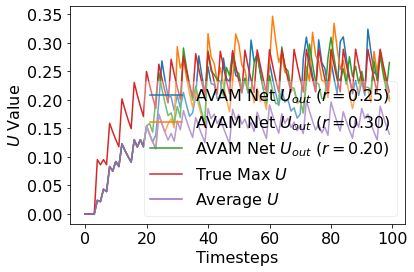

In [27]:
#plt.figure(figsize=(16, 6))
plt.plot(loihi_sim_4.data[max_otpt_4], label="AVAM Net $U_{out}$ ($r=0.25$)")
plt.plot(loihi_sim_5.data[max_otpt_5], label="AVAM Net $U_{out}$ ($r=0.30$)")
plt.plot(loihi_sim_6.data[max_otpt_6], label="AVAM Net $U_{out}$ ($r=0.20$)")
# plt.plot(loihi_sim_7.data[max_otpt_7], label="AVAM Net $U_{out}$ ($r=0.10$)")
# plt.plot(loihi_sim_8.data[max_otpt_8], label="AVAM Net $U_{out}$ ($r=0.50$)")
# plt.plot(loihi_sim_9.data[max_otpt_9], label="AVAM Net $U_{out}$ ($r=1.00$)")
# plt.plot(loihi_sim_10.data[max_otpt_10], label="AVAM Net $U_{out}$ ($r=0.05$)")
plt.plot(ngo_sim_max.data[otpt_probe_max], label="True Max $U$")
plt.plot(ngo_sim_avg.data[otpt_probe_avg], label="Average $U$")
plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.xlabel("Timesteps", fontsize=FONTSIZE)
plt.ylabel("$U$ Value", fontsize=FONTSIZE)
plt.legend(framealpha=0.325, fontsize=FONTSIZE)
plt.savefig("avam_net_poc", dpi=450, bbox_inches="tight")

# #################################################################

In [2]:
ret_dict, num_imgs = get_isi_distribution("model_1", "mnist")
pickle.dump(ret_dict, open("mnist_model_1_isi_distribution_training_imgs.p", "wb"))

Keys in Layers Otpts Dict:  dict_keys(['conv2d_1.0', 'conv2d_2.0'])
Length of Layer Otpts marix: 1000
Shape of first element of Layer Otpts: (50, 2048)
Length of Layer Otpts marix: 1000
Shape of first element of Layer Otpts: (50, 1936)


In [3]:
ret_dict, num_imgs = get_isi_distribution("model_1", "cifar10")
pickle.dump(ret_dict, open("cifar10_model_1_isi_distribution_training_imgs.p", "wb"))

Keys in Layers Otpts Dict:  dict_keys(['conv2d_1.0', 'conv2d_2.0'])
Length of Layer Otpts marix: 1000
Shape of first element of Layer Otpts: (50, 2048)
Length of Layer Otpts marix: 1000
Shape of first element of Layer Otpts: (50, 2048)
